Author: Abdulrahman Altahhan, Jan 2023.

The notebook use a library of functionality in RL that aims for simplicity and general insight into how algorithms work, these libraries are written from scratch using standard python libraries (numpy, matplotlib etc.).
Please note that you will need to take a permission from the author to use the code for research, commercially or otherwise.

# Lesson 3- Dynamic Programming: Model-Based Approach

**Learning outcomes**
1. understand what we mean by the dynamics of the environment
2. understand how the environment's dynamics are used in the Bellman equation
3. use the dynamics to estimate the value function and the action-value function via dynamic programming 
4. understand the policy improvement theorem
5. understand the policy-iteration and value-iteration algorithms as the backbone of many RL algorithms

In the first lesson, you looked at a basic RL problem, the k-arm bandit, which involves only actions and no states (non-associative problem). In general, in RL, we are faced with different situations, and we need to take different actions in each situation in order to achieve a certain goal. This general type of environment with states and actions imposes a different flavour to the solution we can design. From now on, we will tackle associative problems. For associative problems, there are two approaches:

1. Model-based approach
2. Model-free approach

In this lesson, we will take the first approach. We will learn how to use a model of the environment to solve an RL problem. The model is given in the form of the dynamics of the environment. These usually come in the form of 4 dimensions of conditional probability involving an answer to the following question: what is the probability of obtaining a certain reward r in a certain state s' given that the agent was previously in a state s and applied action a.

We will assume that there is already a model for the environment and try to take advantage of this model to come up with the best policy. Nevertheless, we will see simple ways to build such models and come back to this question later when we tackle planning algorithms in RL.

**Reading**:
The accompanying reading of this lesson are **chapters 3 and 4** from our text book by Sutton and Barto available online [here](http://incompleteideas.net/book/RLbook2020.pdf).

**Plan**
As usual, in general there are two types of RL problems that we will attempt to design methods to deal with 
1. Prediction problem
For These problems we will design Policy Evaluation Methods that attempt to find the best estimate for the value-function given a policy.


2. Control problems 
For These problems we will design Value Iteration methods which utilise the idea of Generalised Policy Iteration. They attempt to find the best policy, via estimating an action-value function for a current policy then moving to a better and improved policy by choosing a greedy action often.


In [1]:
%matplotlib inline

In [2]:
import nbimporter
from Lesson2_GridWorldMDPs import * #Grid, randwalk, grid, cliffwalk, windy, cliffwalk, maze, maze8

We start by generating conditional probabilities from random joint probabilities, then we move into generating them from a model.

## 1D Probability
Let us start by defining a 1D probability function 

In [3]:
def P(nS):
    p = np.zeros(nS)
    for s in range(nS):
        p[s] = rand()
        
    return p/p.sum()
p = P(5)
print(p, p.sum())


[0.35513626 0.29148414 0.008207   0.03123475 0.31393786] 1.0


## 2D Probability: Joint Probability
Let us move to defining a joint probability function 

In [5]:
def P(nS,nA):
    p = np.zeros((nS,nA))
    for s in range(nS):
        for a in range(nA):
            p[s,a] = rand()
            
        
    # /p.sum() to make sure that this is a joint probability density, i.e. p.sum()==1
    return p/p.sum() 
p = P(5,2)
print(p, p.sum())

[[0.13859115 0.13435588]
 [0.05054938 0.14326937]
 [0.13463159 0.07785564]
 [0.09074469 0.01708724]
 [0.10158592 0.11132915]] 1.0


Note that p[s,a] in the above is interpreted as the probability of being in state *s* and taking action *a* at the same time

## 2D Probability: Conditional Probability
Let us move to defining a conditional probability function. Remember that a conditional probability must satisfy that Bayes rule.

In the below pr[sn,a] is interpreted as pr[sn|a] the probability of moving to state sn given that we took action a 

In [6]:
def P(nS,nA):
    pr = np.zeros((nS,nA)) # joint
    p  = np.zeros((nS,nA)) # conditional
    
    # first create a joint probability
    for sn in range(nS):
        for a in range(nA):
            pr[sn,a] = rand()

    # to make sure that this is a joint probability density
    pr=pr/pr.sum() 
    
    # now create a conditional probability via Bayes rule
    for a in range(nA):
        p[:,a] = pr[:,a]/pr[:,a].sum()
            
            
    return p

p = P(5,2)
print(p)
print(p.sum(0))

[[0.31867449 0.23421998]
 [0.23175184 0.20671174]
 [0.13190003 0.30968032]
 [0.10519547 0.24294188]
 [0.21247818 0.00644607]]
[1. 1.]


## 4D Probability: Random Dynamic

Our goal now is to be able to obtain a probability that can represent a random environment dynamics. Such a probability has the form of p[sn,rn | s,a] which represents the probability of moving to next state sn and obtaining the reward rn given that the agent was in state s and took action a.

We generalise the above method of obtaining conditional probabilities from random joint probability density to 4-d. We have not dealt with 3-d cases for brevity. This time we will make it a bit more efficient by avoiding the four for loops and utilising the vectorised version of the rand() function in numpy and we convert to a conditional in-place to avoid having two probabilities p and pr.

In [8]:
def dynrand(nS, nA, nR): # states, actions, rewards dimensions 
    #first joint: p[sn,rn, s,a]
    p  = np.random.rand(nS,nR,  nS,nA)
    p /= p.sum()
    
    #convert it to conditional: p[sn,rn| s,a] 
    for s in range(nS):
        for a in range(nA):
            p[:,:, s,a] /= p[:,:, s,a].sum()
        
    return p

p = dynrand(3,2,2)
print(p)
print(p.sum(0).sum(0))

[[[[0.32046774 0.26616449]
   [0.0976896  0.00035689]
   [0.26008775 0.19550748]]

  [[0.03013506 0.03301488]
   [0.30733709 0.21549492]
   [0.00581461 0.17453613]]]


 [[[0.11984678 0.18982569]
   [0.21331026 0.04930323]
   [0.29765206 0.19934832]]

  [[0.23475825 0.27352042]
   [0.09998503 0.26218639]
   [0.10319729 0.02678356]]]


 [[[0.13053225 0.12565188]
   [0.15617915 0.203724  ]
   [0.12914727 0.25886976]]

  [[0.16425992 0.11182264]
   [0.12549887 0.26893457]
   [0.20410102 0.14495475]]]]
[[1. 1.]
 [1. 1.]
 [1. 1.]]


## Inducing the dynamics by interacting with the environment

Now we move into obtaining the dynamics form an actual environment instead of generating the dynamics randomly as we did earlier.

We will use mainly the random walk environment and the grid world environment and generate their dynamics. These are deterministic simple environments. Nevertheless, they are very useful to demonstrate the ideas of RL. 

Note that when we move to the real world the dynamics becomes much more complex and building or obtaining the dynamic becomes impractical form most cases. Therefore, towards that end instead of dealing directly with the environment dynamics we will see later how we can substitute this requirement by having to *interact* with the environment to gain *experience* which will help us *infer* a good *estimate* of the *expected* value function (discounted sum of rewards) which in turn will help us to *infer* a close to *optimal policy* for the task in hand. 

The exercise of dealing with probabilities and then using it in designing a Dynamic Programming solution is valuable since most of other solutions utilise the basic ideas (policy iteration, value iteration algorithms and policy improvements theorem) that we cover here and will mainly show us that we can devise a from of Bellman equation that is suitable for interaction instead of probabilities.

Dynamic programming suffers from what Bellman described as the curse of dimensionality which basically dictates that the computational resources required to solve a problem grows exponentially with the dimensionality of the problem. So in our case the dimensionality is the number of states (as well as actions and rewards). So for example if the dynamic programming solution computational complexity is $2^{|S|}$ and the number of states $|S|=10$ then it costs $2^{10}=1024$ but when the number of states $|S|$ grows to 100 the cost become $2^{100}=1267650600228229401496703205376$

In [11]:
print(2**10)
print(2**100)


1024
1267650600228229401496703205376


In [9]:
def dynamics(env=randwalk(), show=True, stoch=True, repeat=1000 ): #, maxjump=1
    rewards = env.rewards_set()
    nS, nA, nR = env.nS, env.nA, rewards.shape[0]
    p  = np.zeros((nS,nR,  nS,nA))
    
    for i in range(repeat if not stoch else 1): # in case the env is stochastic (non-deterministic)
        for s in range(nS):
            for a in range(nA):
                if not i and show: env.render() # render the first repitition only
                env.s = s
                sn,rn,_,_ = env.step(a)
                rd = np.where(rewards==rn)[0][0] # get which reward index we need to update
                #if (s!=sn) ^ (s in env.goals): p[sn,rd, s,a] +=1 # xor this would give terminal states a pr 1!
                if (s!=sn) and not (s in env.goals): p[sn,rd, s,a] +=1
            
    # making sure that it is a conditional probability that satisfies Bayes rule
    for s in range(nS):
        for a in range(nA):
            sm=p[:,:, s,a].sum()
            if sm: p[:,:, s,a] /= sm
            
    return p

Note that states and actions can be immediately interpreted as indexes, rewards on the other hand are allowed to be real values. Therefore, we need to obtain the index of the reward value that we need to update since p[sn, rn, s,a] expects an index in rn.

Let us now test our dynamics extraction procedure on a deterministic random walk environment:

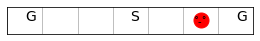

(7, 2, 7, 2)
[[0. 0.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [0. 0.]]


In [11]:
p = dynamics(env=randwalk())
print(p.shape)
print(p.sum(0).sum(0))
# print(p)

The above shows that the probabilities of agent having been in state 0:6 (rows) and have gone left (column 0) all sum up to 1 except for the last terminal state 6 because once the agent is there it stays there and cannot move left. Also it shows equally that the probabilities of agent having been in state 0:6 and have gone right (column 1) all sum up to 1 except for the first terminal state 0 because once the agent is there it stays there and cannot move right. 

To further explain and dissect the generated probability dynamics we examine different states probabilities with different rewards.

In [12]:
def print_dynamcis(s):
    print('-----------------------------Agent was in non-terminal state %d---------------------------------'%s)
    print('Pr[of moving to states 0:6 and obtaining reward 0 |give agent was in state %d and moved left(0)]'%s)
    print(p[:,0, s,0])

    print('Pr[of moving to states 0:6 and obtaining reward 0 |give agent was in state %d and moved right(1)]'%s)
    print(p[:,0, s,1])

    print('Pr[of moving to states 0:6 and obtaining reward 1 |give agent was in state %d and moved left(0)]'%s)
    print(p[:,1, s,0])

    print('Pr[of moving to states 0:6 and obtaining reward 1 |give agent was in state %d and moved right(1)]'%s)
    print(p[:,1, s,1])

In [13]:
print_dynamcis(s=2)

-----------------------------Agent was in non-terminal state 2---------------------------------
Pr[of moving to states 0:6 and obtaining reward 0 |give agent was in state 2 and moved left(0)]
[0. 1. 0. 0. 0. 0. 0.]
Pr[of moving to states 0:6 and obtaining reward 0 |give agent was in state 2 and moved right(1)]
[0. 0. 0. 1. 0. 0. 0.]
Pr[of moving to states 0:6 and obtaining reward 1 |give agent was in state 2 and moved left(0)]
[0. 0. 0. 0. 0. 0. 0.]
Pr[of moving to states 0:6 and obtaining reward 1 |give agent was in state 2 and moved right(1)]
[0. 0. 0. 0. 0. 0. 0.]


In [14]:
print_dynamcis(s=5)

-----------------------------Agent was in non-terminal state 5---------------------------------
Pr[of moving to states 0:6 and obtaining reward 0 |give agent was in state 5 and moved left(0)]
[0. 0. 0. 0. 1. 0. 0.]
Pr[of moving to states 0:6 and obtaining reward 0 |give agent was in state 5 and moved right(1)]
[0. 0. 0. 0. 0. 0. 0.]
Pr[of moving to states 0:6 and obtaining reward 1 |give agent was in state 5 and moved left(0)]
[0. 0. 0. 0. 0. 0. 0.]
Pr[of moving to states 0:6 and obtaining reward 1 |give agent was in state 5 and moved right(1)]
[0. 0. 0. 0. 0. 0. 1.]


Note that the probability of the penultimate state is a bit different than a mid-state such as 2. The reason is that when the agent move left it will get a 0 reward while when it moves right it will get a reward of 1.

In [27]:
print_dynamcis(s=0)

-----------------------------Agent was in non-terminal state 0---------------------------------
Pr[of moving to states 0:6 and obtaining reward 0 |give agent was in state 0 and moved left(0)]
[0. 0. 0. 0. 0. 0. 0.]
Pr[of moving to states 0:6 and obtaining reward 0 |give agent was in state 0 and moved right(1)]
[0. 0. 0. 0. 0. 0. 0.]
Pr[of moving to states 0:6 and obtaining reward 1 |give agent was in state 0 and moved left(0)]
[0. 0. 0. 0. 0. 0. 0.]
Pr[of moving to states 0:6 and obtaining reward 1 |give agent was in state 0 and moved right(1)]
[0. 0. 0. 0. 0. 0. 0.]


In [14]:
print_dynamcis(s=6)

-----------------------------Agent was in non-terminal state 6---------------------------------
Pr[of moving to states 0:6 and obtaining reward 0 |give agent was in state 6 and moved left(0)]
[0. 0. 0. 0. 0. 0. 0.]
Pr[of moving to states 0:6 and obtaining reward 0 |give agent was in state 6 and moved right(1)]
[0. 0. 0. 0. 0. 0. 0.]
Pr[of moving to states 0:6 and obtaining reward 1 |give agent was in state 6 and moved left(0)]
[0. 0. 0. 0. 0. 0. 0.]
Pr[of moving to states 0:6 and obtaining reward 1 |give agent was in state 6 and moved right(1)]
[0. 0. 0. 0. 0. 0. 0.]


Uncomment the xor relationship and see the effect on the resultant policy.

## Accommodating for jumps in the environment
Some environments might allow the agent to jump over some obstacles or simply skip cells. For these we define a slightly altered dynamics to take the jumps into account. Below we show the definition.

In [15]:
def dynamics(env=randwalk(), show=True, stoch=False, repeat=1000): # , maxjump=1

    rewards = env.rewards_set()
    nS, nA, nR = env.nS, env.nA, rewards.shape[0]
    p  = np.zeros((nS,nR,  nS,nA))
    randjump = env.randjump
    env.randjump = False # this is needed so that the probability calculations of all intermediate jumps is correctly calculated
    for i in trange(repeat if stoch else 1): # in case the env is stochastic (non-deterministic)
        for s in range(nS):
            for a in range(nA):
                for jump in (range(1,env.jump+1) if randjump else [env.jump]):
                    if not i and show: env.render() # render the first repitition only
                    env.s = s
                    env.jump = jump
                    rn = env.step(a)[1]
                    sn = env.s
                    rd = np.where(rewards==rn)[0][0] # get which reward index we need to update
                    #if (s!=sn) ^ (s in env.goals): p[sn,rd, s,a] +=1 # xor this would give terminal states a pr 1!
                    if (s!=sn) and not (s in env.goals): p[sn,rd, s,a] +=1
    env.randjump = randjump
    # making sure that it is a conditional probability that satisfies Bayes rule
    for s in range(nS):
        for a in range(nA):
            sm=p[:,:, s,a].sum()
            if sm: p[:,:, s,a] /= sm
            
    return p

### State-Transition probability: reward marginalisation

Now that we have induced the dynamics from the *environment*, we are ready to infer the state-transition probability from the *dynamics*.  Note that many older papers of RL refer to the 3-d state-transition probability without referring to the 4-d dynamics. The state-transition probability p[sn | s,a] is a conditional probability that specifies the probability of moving to the next state sn given that the agent was in state s and applied action a regardless of the rewards. In other words, the state-transition probability does not refer to the reward altogether. Therefore, all we have to do to infer it from the dynamics is to marginalise the dynamics with respect to the reward, which is what the below code snippet is doing.

In [16]:
# state-transition probability induced from the dynamics
def ssa(p): 
    # states dim, action dim
    nS, nA = p.shape[0], p.shape[3]
    tr = np.zeros((nS, nS, nA))
    for s in range(nS):
        for a in range(nA):
            for sn in range(nS):
                tr[sn, s,a] = p[sn,:,s,a].sum()
    return tr

Let us now apply this function on the obtained random walk dynamics.

In [17]:
tr = ssa(p)
print(tr.sum(0))
# print(tr)

[[0. 0.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [0. 0.]]


Again the state-transition probability satisfies similar properties of the dynamics.

Finally, we can apply a similar logic to obtain the reward function, see page 49 of the book.

In [18]:
# reward function induced from the dynamics
def rsa(p, rewards):
    # state dim, reward dim
    nS, nA, nR = p.shape[0], p.shape[3], p.shape[1]
    r = np.zeros((nS,nA))
    for s in range(nS):
        for a in range(nA):
             for rd, rn in enumerate(rewards):
                r[s,a] += rn*p[:,rd, s,a].sum()
    return r


In [19]:
rewards = randwalk().rewards_set()
r = rsa(p, rewards)
print(r)

[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 1.]
 [0. 0.]]


This shows us that the expected reward of state-aciton pair (5,right)=1 and (6,right)=1. This is because we expect the agent to obtain a reward of 1 in the future when it move right while it was in state 5 because it will end up in the right terminal state which has a reward of 1. Also we have (6,right)=1 because once the agent is at the terminal state 6 it will stay there.

# Dynamic Programming Methods

Ok so we are ready now to move to Dynamic programming algorithms to solve the RL problem of finding a best estimate of a value function and or finding an optimal policy.

## Policy evaluation

The first step to improving any policy is to evaluate how good or bad the policy is for the given task. This fundamental question can be addressed by tying up the task with a reward function that basically rewards the agent for achieving the task or a subtask that leads to the final goal. The agent's aim then becomes to collect as many rewards as possible (or to incur as few losses as possible), which should help the agent achieve the given task. One example is when a robot is moving in an environment, and we want it to reach a specific location, then we can reward/punish the robot for each step that is taking it close to the goal or away from it. But this awareness of the goal location is usually difficult to attain in real environments. Hence it is replaced by rewarding the agent when it reaches the goal or punishing the agent for each step taken without reaching the goal location.

We can devise an evaluation strategy based on the discounted sum of rewards the agent is *expected* to collect while executing the task. The strategy depends on the dynamics of the environment. You may want to read section 4.1 and come back here to continue reading the code for the policy evaluation algorithm to get an insight into how it works.

In [20]:
np.random.seed(1) # change the seed to get a different dynamics

def Policy_evaluation(env=randwalk(), π=None, p=None, show=True, v0=.01, V0=None, θ=1e-3, γ=1, 
                      isrand=False, stoch=False): 
    nS, nA, nR = env.nS, env.nA, env.nR
    
    # m states, k actions and d rewards returns a 4-d dynamics
    if isrand:      p = dynrand(nS, nA, nR);          rewards = [-1,1] 
    elif p is None: p = dynamics(env=env, show=show, stoch=stoch); rewards = env.rewards_set() #maxjump=maxjump
    else:                                             rewards = env.rewards_set()# obtain a model of the env
        
    #V  = np.ones(nS )*v0; V[env.goals] = 0 
    V = np.ones(nS )*v0 if V0 is None else V0.copy()
    V[env.goals] = 0 

    #if π is None: π=np.zeros((nS, nA), dtype=np.uint32); π[:,1]=1 
    if π is None: π=np.ones(nS, dtype=np.uint32) # if π is not passed then always move right
    i=0
    # policy evaluation--------------------------------------------------------------
    while True:
        Δ = 0
        i+= 1
        if not show: clear_output(wait=True); rng = trange(nS) # show some further indication to keep use infromed
        else: rng = range(nS)
        for s in rng:
            v, V[s] = V[s], 0            
            for sn in range(nS):
                for rn, r in enumerate(rewards):
                        if π.ndim == 1: V[s] += p[sn,rn, s,π[s]]*(r + γ*V[sn])# deterministic policy
                        else:
                            for a in range(nA): V[s] += π[s,a]*p[sn,rn, s,a]*(r + γ*V[sn]) # probabilistic policy              
            Δ = max(Δ, abs(v-V[s]))
        if Δ<θ:
            if show: print('policy evaluation stopped @ iteration %d:'%i)
            break
    
    return V

Note that we assume that when the policy is deterministic, it takes the shape (nS,) and its entries are actions ex. π[s]=1 means take right(1) when in state s.

On the other hand if the policy is probabilistic, it has a shape of (nS, nA) and its entries are probabilities of each action given a state s, i.e π[a|s] written as π[s,a] in the code.

Note that γ must be < 1 to guarantee convergence of the Bellman equation because we do not know whether the policy guarantees reaching a terminal(goal) state. This condition can be relaxed when we move to sampling instead of dynamic programming in the next consequent lessons.

Ok, let us test our policy evaluation method on a default policy where the agent goes right always (embedded in the code).

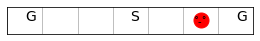

100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

policy evaluation stopped @ iteration 6:


array([0., 1., 1., 1., 1., 1., 0.])

In [21]:
Policy_evaluation()

As we can see, the values for the default deterministic policy that always move the agent to the right produce a set of state values of 1 for the non-terminal states 1:5. This is what we expect since the accumulated return of this policy, given that γ=1, is 1 for these states since the agent is rewarded with 1 only when it reaches the far right terminal state, while when it is terminated at the far left state, it is rewarded with 0 (all other intermediate states also has a reward of 0).

To further test our policy evaluation method, we will pass a different policy to it. This time we pass a simple probabilistic policy that gives left and right actions the same probability of 0.5. In this case, since γ=1, the expected analytical values of the intermediate states are given as 1/6, 2/6, 3/6, 4/6, 5/6, which represent the probabilities of ending up in the far right state given the agent has started in them (so pr(s=1)=1/6).

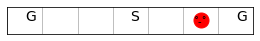

100%|██████████| 1/1 [00:00<00:00,  1.47it/s]

policy evaluation stopped @ iteration 20:


array([0.        , 0.16481679, 0.33055852, 0.49722519, 0.66458556,
       0.83229278, 0.        ])

In [22]:
env = randwalk()
π = np.ones((env.nS,env.nA))*.5 # probability of moving left and right are equal
Policy_evaluation(env, π)

In [23]:
np.array([1/6, 2/6, 3/6, 4/6, 5/6])

array([0.16666667, 0.33333333, 0.5       , 0.66666667, 0.83333333])

As we can see the values of this optimal policy (moving always right) progressively increase from left to right towards the goal that is most rewarding and the obtained values are exactly what we expected which is reassuring.

Let us try to evaluate a random policy

In [23]:
env = randwalk()
π = np.random.randint(env.nA, size=env.nS, dtype=np.uint32)
print(π)

[1 1 0 0 1 1 1]


Now we call our policy evaluaiton subroutine.

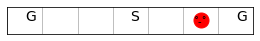

100%|██████████| 1/1 [00:00<00:00,  1.61it/s]

policy evaluation stopped @ iteration 3:


array([0.  , 0.01, 0.01, 0.01, 1.  , 1.  , 0.  ])

In [24]:
Policy_evaluation(env, π)

As we can see the set of values are different than the above optimal policy and they are in harmony with the policy.

### Policy Evaluation for Grid world

Let us now try this on a slightly more complex env such as a grid world

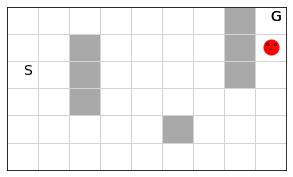

100%|██████████| 1/1 [00:11<00:00, 11.86s/it]


policy evaluation stopped @ iteration 7:
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


In [25]:
env = maze()
π = np.ones(env.nS, dtype=np.uint32)*3 # always go up
V = Policy_evaluation(env=env, π=π)
print(V)

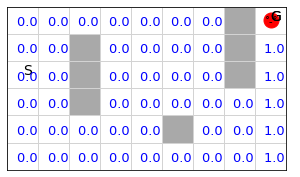

In [26]:
env.render(underhood='V', V=V)

As we can see moving up yeild some benefits mainly in the cells that lead to the goal.

Let us now generate a random policy and evaluate it for a maze environment.

In [27]:
env = maze()
π = np.random.randint(env.nA, size=env.nS, dtype=np.uint32)
print(π)

[1 3 0 0 1 0 3 1 0 2 1 2 0 2 1 2 0 3 0 2 0 1 2 2 0 3 3 1 1 3 2 0 2 1 1 1 3
 3 1 2 1 1 0 0 1 0 0 1 3 3 2 1 0 2]


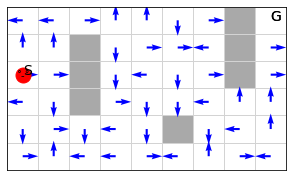

In [28]:
env.render(underhood='π', π=π)

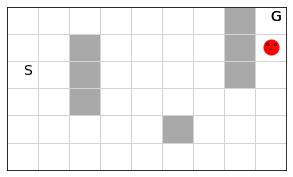

100%|██████████| 1/1 [00:11<00:00, 11.85s/it]

policy evaluation stopped @ iteration 4:


array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.  , 0.  , 0.01, 0.01, 0.01,
       0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.01, 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.  ])

In [29]:
Policy_evaluation(env, π)

As we can see, the randomly generated policy is chaotic and carry little value for the agent. However, evaluating different policies is highly important for an agent since it can guide the improvement of its adopted policy (based on this ability). One example is to keep evaluating random policies until some computational resources are consumed and pick the best. Below we show such a strategy of searching for an optimal policy. You can apply all other search algorithms that you have come across before in conventional AI (breadth-first etc.).

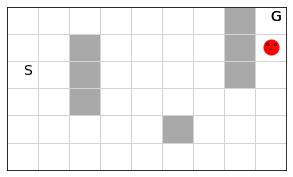

100%|██████████| 1/1 [00:11<00:00, 11.81s/it]


In [30]:
from tqdm import trange
env = maze()
Vmax= np.zeros((env.nS))
p = dynamics(env)

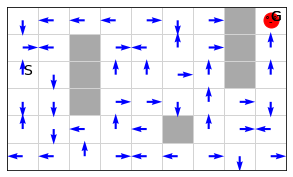

In [31]:
for _ in trange(200):
    π = np.random.randint(env.nA, size=env.nS, dtype=np.uint32)
    V = Policy_evaluation(env, π, p, False)
    if Vmax.sum() < V.sum(): 
        Vmax = V
        πmax = π

env.render(underhood='π', π=πmax)

As we can see, finding the optimal policy by random search is difficult since the space of policies is huge, making exhaustive or random search infeasible (dimensionality problem). We need a way to take and maintain a step in the right direction of improving the policy. As you have already seen in another module, a greedy search can often lead to a good result. The next section shows a simple but effective strategy to gradually improve a policy by taking a greedy step towards the solution.

## Policy Iteration 
Now that we know how to evaluate a policy, it is time to improve it. Policy iteration is a basic and simple algorithm. It explicitly and iteratively tries first to reach a highly accurate estimate of the value function of the current policy, then it tries to improve the policy by maximising the probability of greedy actions as per the current value function. Evaluating the current policy fully and then improving it via policy iteration is inefficient, but it shows the fundamental ideas behind reinforcement learning. Please spend some time comprehending the code and reading the corresponding section 4.3 in the book.

In [32]:
np.random.seed(1) # change the seed to get a different dynamics

def Policy_iteration(env=randwalk(), v0=.01, θ=1e-4, γ=.99, isrand=False): 
    nS, nA, nR = env.nS, env.nA, env.nR
    
    # m states, k actions and d rewards returns a 4-d dynamics
    if isrand: p = dynrand(nS, nA, nR); rewards = [-1,1] 
    else:      p = dynamics(env);       rewards = env.rewards_set() # obtain a model of the env
        
    # 1. initialise arbitrarily -------------------------------------------------
    V  = np.ones (nS )*v0; V[env.goals] = 0 
    π  = np.zeros(nS, dtype=np.uint32) # policy for all states
    Qs = np.zeros(nA) # action-values for individual state
     
    j=0
    while True:
        j+=1
        # 2. policy evaluation---------------------------------------------------
        i=0
        while True:
            Δ = 0
            i+= 1
            for s in range(nS):
                v, V[s] = V[s], 0
                for sn in range(nS):
                    for rn, r in enumerate(rewards):
                        V[s] += p[sn,rn,  s, π[s]]*(r + γ*V[sn])
                Δ = max(Δ, abs(v-V[s]))
            if Δ<θ: print('policy evaluation stopped @ iteration %d:'%i); break

        # 3. policy improvement----------------------------------------------------
        policy_stable=True
        for s in range(nS):
            πs = π[s]
            for a in range(nA):
                Qs[a]=0
                for sn in range(nS):
                    for rn, r in enumerate(rewards):
                        Qs[a] += p[sn,rn,  s,a]*(r + γ*V[sn]) 
            π[s] = Qs.argmax() # greedy step
            if π[s]!=πs: policy_stable=False
        if policy_stable: print('policy improvement stopped @ iteration %d:'%j); break
    return π

We try our policy_iteration() funciton for a random dynamcis:

In [39]:
Policy_iteration(isrand=True)

policy evaluation stopped @ iteration 6:
policy evaluation stopped @ iteration 6:
policy improvement stopped @ iteration 2:


array([0, 0, 0, 0, 0, 1, 0], dtype=uint32)

In [41]:
Policy_iteration(isrand=True)

policy evaluation stopped @ iteration 5:
policy evaluation stopped @ iteration 5:
policy improvement stopped @ iteration 2:


array([1, 0, 0, 0, 0, 0, 1], dtype=uint32)

We can of course try it for a proper Environments. We start by a random walk and then we move into grid world.

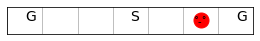

100%|██████████| 1/1 [00:00<00:00,  1.62it/s]

policy evaluation stopped @ iteration 2:
policy evaluation stopped @ iteration 2:
policy evaluation stopped @ iteration 2:
policy evaluation stopped @ iteration 2:
policy evaluation stopped @ iteration 2:
policy evaluation stopped @ iteration 2:
policy improvement stopped @ iteration 6:


In [42]:
env=randwalk()
π = Policy_iteration(env)

To visualise the policy we would need to pass the environment explicitly and then render the environment.

In [43]:
print(π)

[0 1 1 1 1 1 0]


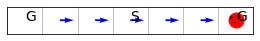

In [44]:
env.render(underhood='π', π=π)

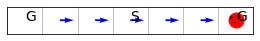

In [45]:
env.render(underhood='π', π=π)

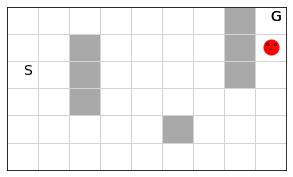

100%|██████████| 1/1 [00:11<00:00, 11.94s/it]


policy evaluation stopped @ iteration 2:
policy evaluation stopped @ iteration 2:
policy evaluation stopped @ iteration 2:
policy evaluation stopped @ iteration 2:
policy evaluation stopped @ iteration 2:
policy evaluation stopped @ iteration 2:
policy evaluation stopped @ iteration 2:
policy evaluation stopped @ iteration 2:
policy evaluation stopped @ iteration 2:
policy evaluation stopped @ iteration 2:
policy evaluation stopped @ iteration 2:
policy evaluation stopped @ iteration 2:
policy evaluation stopped @ iteration 2:
policy evaluation stopped @ iteration 2:
policy evaluation stopped @ iteration 2:
policy evaluation stopped @ iteration 2:
policy improvement stopped @ iteration 16:


In [46]:
env=maze()
π = Policy_iteration(env)

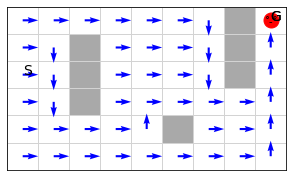

In [47]:
env.render(underhood='π', π=π)

## Stochastic Policy Iteration
We can also create a stochastic policy iteration method. It only differs from the deterministic policy iteration in two places (in the if ε_greedy statements): 
1. in the policy evaluation, we need to marginalize by multiplying by the action probability as we did earlier for the policy evaluation method
2. In calculating the probability of taking an optimal action (to account for the stochastic non-determinism nature of the policy), we allow the agent to take random actions ε% of the time. 

We show the method below.


In [48]:
np.random.seed(1) # change the seed to get a different dynamics

def Policy_iteration_stoch(env=randwalk(), v0=.01, θ=1e-4, γ=.99, ε=.1, isrand=False): 
    nS, nA, nR = env.nS, env.nA, env.nR
    
    # m states, k actions and d rewards returns a 4-d dynamics
    if isrand: p = dynrand(nS, nA, nR); rewards = [-1,3] 
    else:      p = dynamics(env);       rewards = env.rewards_set() # obtain a model of the env
        
    # 1. initialise arbitrarily -------------------------------------------------
    V  = np.ones (nS )*v0; V[env.goals] = 0 
    π  = np.ones((nS, nA)) # probabilistic policy
    for s in range(nS): π[s] /= π[s].sum()
    Q  = np.ones((nS, nA))  # action-values for individual state

    j=0
    while True:
        j+=1
        # 2. policy evaluation---------------------------------------------------
        i=0
        while True:
            Δ = 0
            i+= 1
            for s in range(nS):
                v, V[s] = V[s], 0
                for sn in range(nS):
                    for rn, r in enumerate(rewards):
                        for a in range(nA): 
                            V[s] += π[s,a]*p[sn,rn, s,a ]*(r + γ*V[sn]) # probabilistic policy
                        
                Δ = max(Δ, abs(v-V[s]))
            if Δ<θ: print('policy evaluation stopped @ iteration %d:'%i); break

        # 3. policy improvement----------------------------------------------------
        policy_stable=True
        for s in range(nS):
            if s in env.goals: π[s]=0; continue
            Qs = Q[s]
            for a in range(nA):
                Q[s,a]=0
                for sn in range(nS):
                    for rn, r in enumerate(rewards):
                        Q[s,a] += p[sn,rn, s,a]*(r + γ*V[sn])
                        
                if abs(Q[s,a]-Qs[a]) > 1e-4: policy_stable=False
            π[s] = Qs*0 + ε/nA
            π[s,Q[s].argmax()] += 1-ε     # greedy step  
        if policy_stable: print('policy improvement stopped @ iteration %d:'%j); break

    return π

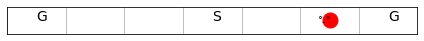

100%|██████████| 1/1 [00:00<00:00,  1.61it/s]

policy evaluation stopped @ iteration 27:
policy improvement stopped @ iteration 1:
[[0.   0.  ]
 [0.05 0.95]
 [0.05 0.95]
 [0.05 0.95]
 [0.05 0.95]
 [0.05 0.95]
 [0.   0.  ]]


In [49]:
env=randwalk(figsize=[25,.5])
π = Policy_iteration_stoch(env=env)
print(π)

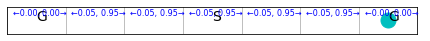

In [50]:
env.render(underhood='Q', Q=π)

As we can see the policy chooses to take right majority of the times  1-ε+ ε/nA=.95 while taking left occasionally  ε/nA.

## Value Iteration Algorithm

Our final step to fully develop the ideas of dynamic programming is to shorten the time it takes for a policy to be evaluated and improved. One simple idea we will follow here is to slightly improve the evaluation and immediately improve the policy. We do these two steps iteratively until our policy has stopped to improve. This is a very effective strategy because we do not wait until the policy is fully evaluated to improve it; we weave and interleave the two loops together in one loop. Below we show this algorithm. Read section 4.4 to further your understanding of this algorithm.

In [51]:
np.random.seed(1) # change the seed to get a different dynamics

def π(Q):
    return [Q[s].argmax() for s in range(Q.shape[0])]

def value_iteration(env=randwalk(), v0=.01, θ=1e-4, γ=.99, isrand=False, show=False): 
    # initialise V randomly but make sure that terminal states = 0
    nS, nA, nR, i = env.nS, env.nA, env.nR, 0
    V = np.ones( nS    )*v0; V[env.goals] = 0 
    Q = np.ones((nS,nA))*v0; Q[env.goals] = 0 

    # p is a 4-d dynamics
    if isrand: p = dynrand(nS, nA, nR); rewards = [-1,1] 
    else:      p = dynamics(env, show); rewards =  env.rewards_set()
    
    while True:
        Δ = 0
        i+= 1
        for s in range(nS):
            v, Q[s] = V[s], 0
            for a in range(nA):
                for sn in range(nS):
                    for rd, rn in enumerate(rewards):
                        Q[s,a] += p[sn,rd,  s,a]*(rn + γ*V[sn])  # max operation is embedded now in the evaluation
            V[s] = Q[s].max()                                    # step which made the algorithm more concise 
            Δ = max(Δ, abs(v-V[s]))
            
        if Δ<θ: print('loop stopped @ iteration: %d , Δ = %2.f'% (i, Δ)); break
    return Q

In [52]:
env = randwalk()
policy = π(value_iteration(env))
print('optimal action for state', policy)

100%|██████████| 1/1 [00:00<?, ?it/s]

loop stopped @ iteration: 6 , Δ =  0
optimal action for state [0, 1, 1, 1, 1, 1, 0]


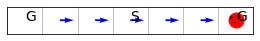

In [53]:
env.render(underhood='π', π=policy)

As we can see our value iteration algorithm is effective in finding the optimal policy. Note that for the random walk environment the best policy is to move right to get a reward.

### Value Iteration on a Grid World

Now that you understand the value-iteration algorithm, you can apply it on a different and more complex envornment such as the grid world. As we did for the random walk, you have access to a grid world via the Grid class and its subroutines.

In [54]:
env=grid()
policy = π(value_iteration(env))
print('optimal action for state', policy)

100%|██████████| 1/1 [00:00<00:00, 1000.55it/s]


loop stopped @ iteration: 10 , Δ =  0
optimal action for state [1, 1, 1, 1, 1, 1, 3, 0, 0, 0, 1, 1, 1, 1, 1, 1, 3, 0, 0, 0, 1, 1, 1, 1, 1, 1, 3, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 0, 0, 0]


To interpret the policy we provided you with a useful funciton to rebder the environemt with its policy, we show that below.

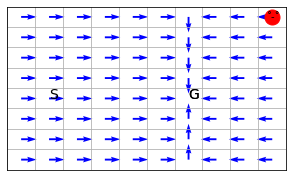

In [56]:
env.render(underhood='π', π=policy)

As we can see the policy-iteration algorithm successfuly gave us the best policy for this simple environment.

### Value Iteration on a Windy Grid World
Below we show the results of applying the value iteration method on a windy grid world. This is almost identical to the previous simple grid world without any obstacles, the only difference is that there is a wind blowing upwards, which shifts the agent 2 or 1 cell depending on its location. See page 130 of the book.

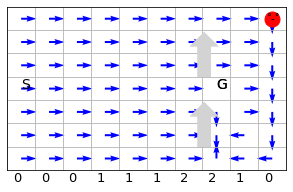

In [73]:
env=windy()
policy = π(value_iteration(env))
print('optimal action for state', policy)
env.render(underhood='π', π=policy)

### value iteration on a maze
Let us now apply the policy-iteration on the maze env.

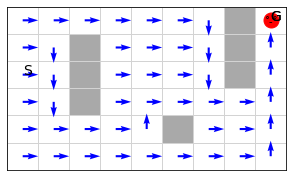

In [57]:
env=maze()
policy = π(value_iteration(env))
print('optimal action for state', policy)
env.render(underhood='π', π=policy)

## Conclusion
In this lesson, we covered the main dynamic programming algorithms. We saw how evaluating a policy was extremely useful in being the key component to allowing us to improve the policy. We then developed a policy iteration algorithm which improves the policy in two main steps:
1. a step that evaluates the policy fully to reach an accurate estimation of the action values of the current policy
2. a step that improves the policy by adopting a greedy action. The usage of an action-value function Q(s,a) was key in allowing us to choose between actions since the state-value function V(s) does not differentiate between the values of actions

We finally saw how the value-iteration algorithm has a similar structure to the policy-iteration algorithm with one important difference; it can arrive at an optimal policy by just taking a step *towards* the optimal policy by slightly refines its estimation of the action-value function without fully evaluating it.  Hence, it improves its policy more concisely and with much less overhead than the full policy iteration method.

In the next lesson, we will take a different approach and move to cover sampling methods that do not use the dynamics of the environment explicitly and instead try to improve its policy by interacting with the environment.


## Your turn
Try the policy iteration on the maze8 which allows the agent to move diagonally, it is fun.

You should arrive to an optimal policy for this maze environment where agent can move diagonally and has 8 actions. You should be able to observe how efficient the policy is and how the agent is able to reach the goal location from anywhere in the environment.


## Challenges
1. Alter policy_iteration_stoch to use a softmax policy instead of the ε-greedy policy that we used in the policy_iteration_stoch method.
2. You can challenge yourself also by trying to combine policy_iteration and policy_iteration_stoch() in one method. Use a flag such as ε_greedy to distinguish between deterministic and probabilistic policies.